In [312]:
import requests
import os
import sys
import pandas as pd
import numpy as np


from typing import Optional
import glob
from scipy import stats
# Add the parent directory of this notebook to sys.path
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(parent_dir)

from project_tools import project_utils, project_class

import datetime
import json
from tqdm.notebook import tqdm
import gc
# import ds_utils
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, ndcg_score
from scipy.stats import kendalltau, spearmanr
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss, accuracy_score
from scipy import stats
%matplotlib inline

from importlib import reload
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.0f' % x)

# Or for more precise control
pd.set_option('display.float_format', '{:.5f}'.format)

# load_data 

In [2]:
# train_horse_race_df = pd.read_parquet('../feature_data/train_horse_race_df.parquet')
# val_horse_race_df = pd.read_parquet('../feature_data/val_horse_race_df.parquet')                           
horse_race_df = pd.read_parquet('../feature_data/horse_race_df.parquet')

In [3]:
# load generated featureset
!ls ../feature_data/

basic_cat_ordinal_features.parquet
horse_class_feats.parquet
horse_feats.parquet
horse_race_df.parquet
horse_running_position_features.parquet
horse_track_running_position_features.parquet
race_course_features.parquet
track_condition.parquet
train_horse_positions_df.parquet
train_horse_race_df.parquet
train_jockey_positions_df.parquet
train_trainer_positions_df.parquet
val_horse_race_df.parquet


In [4]:
# load features
basic_cat_ordinal_df = pd.read_parquet('../feature_data/basic_cat_ordinal_features.parquet')

In [5]:
print(horse_race_df.shape)
print(basic_cat_ordinal_df.shape)

(29520, 44)
(29520, 6)


In [6]:
# load baseline evaluation result

In [7]:
baseline_mean_results = pd.read_parquet('../evaluation_results/valdf_random_winodd_baseline_mean_results.parquet')

In [8]:
baseline_mean_results

,random_probs,winning_odd_preds
Winner Match,0.07632,0.29354
Top 3 Set Match,0.00783,0.05871
Top 3 Exact Match,0.00196,0.00978


# evaluation functions

In [27]:
def evaluate_horse_race_positions(y_true, y_pred_proba, dnf_value=99):
    """
    Evaluate predictions for a single race's finishing positions.
    
    Args:
        y_true: 1D array of true finishing positions
        y_pred_proba: 1D array of predicted probabilities
        dnf_value: Value used to indicate Did Not Finish
        
    Returns:
        Dictionary of evaluation metrics
    """
    # Handle NaN and DNF values in ground truth
    y_true_processed = y_true.copy()
    invalid_mask = np.logical_or(
        np.isnan(y_true),
        y_true == dnf_value
    )
    
    # Get max valid rank (excluding DNF values)
    valid_ranks = y_true[~invalid_mask]
    if len(valid_ranks) > 0:
        max_rank = np.max(valid_ranks)
        # Replace invalid values with max_rank + 1
        y_true_processed[invalid_mask] = max_rank + 1
        
    # Winner match
    y_true_ranksort = np.argsort(y_true_processed)
    y_pred_ranksort = np.argsort(y_pred_proba, axis=0)[::-1]
    
    winner_match = y_true_ranksort[0] == y_pred_ranksort[0]
    
    # Top 3 Set Match - considers [1,3,2] and [2,3,1] as matching
    top3_set_match = set(y_true_ranksort[:3]) == set(y_pred_ranksort[:3])
    
    # Top 3 Exact Match - only considers exact matches like [1,3,2] and [1,3,2]
    top3_exact_match = np.array_equal(y_true_ranksort[:3], y_pred_ranksort[:3])
    
    return {
        'Winner Match': float(winner_match),
        'Top 3 Set Match': float(top3_set_match), 
        'Top 3 Exact Match': float(top3_exact_match)
    }


In [28]:
def evaluate_prediction_sets(eval_dict):
    """
    Evaluate different prediction sets against ground truth for each race and calculate mean metrics
    
    Args:
        eval_dict: Dictionary containing race data with ground truth and different prediction sets
        
    Returns:
        tuple: (eval_result, mean_results_df)
            - eval_result: Dictionary with detailed evaluation metrics for each race
            - mean_results_df: DataFrame comparing mean metrics across prediction types
    """
    # Initialize results dictionary with race_ids as first level keys
    eval_result = {race_id: {} for race_id in eval_dict}

    # Get prediction types from first race data
    first_race_id = next(iter(eval_dict))
    pred_types = [key for key in eval_dict[first_race_id].keys() if key != 'ground_truth']

    # Initialize dictionaries to store mean results
    mean_results = {pred_type: {} for pred_type in pred_types}

    # Loop through each race
    for race_id in eval_dict:
        race_data = eval_dict[race_id]
        ground_truth = race_data['ground_truth']
        
        # Evaluate each prediction type
        for pred_type in pred_types:
            pred_probs = race_data[pred_type]
            
            # Evaluate predictions for this race
            race_eval = evaluate_horse_race_positions(
                ground_truth,
                pred_probs
            )
            
            # Store results for this race under race_id first, then pred_type
            eval_result[race_id][pred_type] = race_eval

    # Calculate mean results for each prediction type
    for pred_type in pred_types:
        # Initialize dict to store means for each metric
        metric_means = {}
        
        # Get metrics from first race to know what metrics exist
        first_race = next(iter(eval_result.values()))
        metrics = first_race[pred_type].keys()
        
        # For each metric, calculate mean across all races
        for metric in metrics:
            total = 0
            num_races = 0
            for race_id in eval_result:
                total += eval_result[race_id][pred_type][metric]
                num_races += 1
            metric_means[metric] = total / num_races
            
        mean_results[pred_type] = metric_means
    
    # Convert mean results to DataFrame for easy comparison
    mean_results_df = pd.DataFrame(mean_results)
    
    return eval_result, mean_results_df

# # Run evaluation
# eval_result, mean_results_df = evaluate_prediction_sets(eval_dict)

# # Display mean results comparison
# print("\nMean Evaluation Metrics Comparison:")
# print(mean_results_df)


# lightgbm training function

In [29]:
def train_lightgbm_model(train_df, val_df, label_col, cat_features=None, params=None):
    """
    Train a LightGBM model for binary classification using LGBMClassifier
    
    Args:
        train_df: Training dataframe containing features and label
        val_df: Validation dataframe containing features and label  
        label_col: Name of label column (should contain binary values 0/1)
        cat_features: List of categorical feature names
        params: Dict of LightGBM parameters
        
    Returns:
        Trained model and validation predictions
    """
    # Default parameters if none provided
    if params is None:
        params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'boosting_type': 'gbdt',
            'n_estimators':150,
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9,  # Column sampling
            'bagging_fraction': 0.8,  # Row sampling 
            'bagging_freq': 5,
            'verbose': -1,
            'max_depth': -1,
            'min_child_samples': 20,
            'reg_alpha': 0.0,
            'reg_lambda': 0.0,
            'is_unbalance': True  # Handle unbalanced datasets
        }

    # Separate features and labels
    features = [col for col in train_df.columns if col != label_col]
    X_train = train_df[features]
    y_train = train_df[label_col]
    X_val = val_df[features]
    y_val = val_df[label_col]

    # Initialize and train model
    model = LGBMClassifier(**params)
    
    # Fit model with early stopping
    model.fit(
        X_train, y_train,
        categorical_feature=cat_features if cat_features else 'auto'
    )
    
    # Make validation predictions
    val_preds = model.predict_proba(X_val)[:, 1]  # Get probability of positive class
    val_logloss = log_loss(y_val, val_preds)
    # val_acc = accuracy_score(y_val, val_preds > 0.5)  # Convert probs to binary predictions
    print(f'Validation LogLoss: {val_logloss:.4f}')
    # print(f'Validation Accuracy: {val_acc:.4f}')
    
    return model, val_preds

In [18]:
print(horse_race_df.shape)
print(basic_cat_ordinal_df.shape)

(29520, 44)
(29520, 6)


# enhanced modelling with additional features

<module 'project_tools.project_class' from '/home/yifan/playground/hk_horse_racing/project_tools/project_class.py'>

In [53]:
!ls ../feature_data/

basic_cat_ordinal_features.parquet
horse_class_feats.parquet
horse_feats.parquet
horse_race_df.parquet
horse_running_position_features.parquet
horse_track_running_position_features.parquet
race_course_features.parquet
trace_condition.parquet
train_horse_positions_df.parquet
train_horse_race_df.parquet
train_jockey_positions_df.parquet
train_trainer_positions_df.parquet
val_horse_race_df.parquet


## uniform feature - part 1

In [41]:


# basic_num_features = ['horse_number', 'clean_actual_weight', 'clean_declared_horse_weight',
#                   'clean_win_odds', 'race_distance', 'clean_position_mavg_3', 'clean_position_mavg_5',
#                      'clean_position_mavg_7']


basic_num_features = ['horse_number', 'clean_actual_weight', 'clean_declared_horse_weight',
                  'clean_win_odds', 'race_distance']


basic_cat_features = basic_cat_ordinal_df.columns.tolist()

df0 = pd.concat([horse_race_df[basic_num_features], basic_cat_ordinal_df], axis=1)
# df0[target] = horse_race_df[target]


In [10]:
basic_cat_ordinal_df.columns

Index(['jockey', 'trainer', 'race_course', 'race_course_track', 'race_class',
       'track_condition'],
      dtype='object')

In [42]:
reload(project_class)
reload(project_utils)


# binary encoding
lbl_enc = project_class.DataFrameLabelTransformer()
lbl_df = lbl_enc.fit_transform(horse_race_df[basic_cat_features].copy())

binary_enc = project_class.DataFrameBinaryEncoder(cat_cols=basic_cat_features,  verbose=False)
bin_df = binary_enc.fit_transform(lbl_df)

freq_df = project_utils.freq_encoding(lbl_df)

print(lbl_df.shape, bin_df.shape,freq_df.shape)

(29520, 6) (29520, 27) (29520, 6)


In [43]:
horse_feats = pd.DataFrame()
horse_feats['awght_dwght_ratio'] = horse_race_df['clean_actual_weight'] / horse_race_df['clean_declared_horse_weight']
horse_feats['awght_dwght_delta'] = horse_race_df['clean_actual_weight'] - horse_race_df['clean_declared_horse_weight']

# moving feature for horse, trainer and jockey

In [205]:

def calculate_running_position_stats(df, mavg_feature, target_col='clean_position', 
                                     calculate_offset = True,
                                     specific_value=None):
    """
    Calculate running averages of a feature for each horse based on their previous 3, 5 and 7 races,
    excluding the current race to avoid data leakage.
    
    Args:
        df: DataFrame containing horse race data with horse_id and feature columns
        horse_id_feature: Column name containing horse IDs
        feature_col: Name of the column to calculate running averages for (default: 'clean_position')
        specific_value: Value to replace with NaN if specified
        
    Returns:
        DataFrame with added columns for running averages of previous races
    """
    # Create copy to avoid modifying original
    result_df = df[[mavg_feature]].copy()
    
    # Initialize new columns
    result_df[f'{mavg_feature}_{target_col}_mavg_3'] = np.nan
    result_df[f'{mavg_feature}_{target_col}_mavg_5'] = np.nan 
    result_df[f'{mavg_feature}_{target_col}_mavg_7'] = np.nan

    # Get unique horses
    horses = df[mavg_feature].unique()
    
    # Calculate running averages for each horse
    for horse in horses:
        # Get all races for this horse in chronological order
        horse_mask = df[mavg_feature] == horse
        horse_data = df[horse_mask].copy()
        
        # Get feature values, replacing specific value with nan if needed
        if specific_value is not None:
            values = horse_data[target_col].replace(specific_value, np.nan)
        else:
            values = horse_data[target_col]
            
        # Calculate means of previous races for each row
        for i in range(len(horse_data)):
            if calculate_offset:
                prev_values = values.iloc[:i]  # Only use races before current row
            else:
                prev_values = values
            # Calculate means if we have enough previous races
            if len(prev_values) >= 3:
                result_df.loc[horse_data.index[i], f'{mavg_feature}_{target_col}_mavg_3'] = prev_values.tail(3).mean()
            if len(prev_values) >= 5:
                result_df.loc[horse_data.index[i], f'{mavg_feature}_{target_col}_mavg_5'] = prev_values.tail(5).mean()
            if len(prev_values) >= 7:
                result_df.loc[horse_data.index[i], f'{mavg_feature}_{target_col}_mavg_7'] = prev_values.tail(7).mean()
                
    return result_df

In [199]:
horse_race_df = horse_race_df.sort_values(by=['clean_race_date','race_id'], ascending=True).reset_index(drop=True)

In [200]:
mvg_horse_position_df = calculate_running_position_stats(horse_race_df, 'horse_id', 
                                                target_col='clean_position')

In [201]:
mvg_jockey_position_df = calculate_running_position_stats(horse_race_df, 'jockey', 
                                                target_col='clean_position')

In [203]:
mvg_trainer_position_df = calculate_running_position_stats(horse_race_df, 'trainer', 
                                                target_col='clean_position')

In [236]:
tid = mvg_trainer_position_df['trainer'].sample(1).values[0]
mvg_trainer_position_df[mvg_trainer_position_df['trainer']==tid]

,trainer,trainer_clean_position_mavg_3,trainer_clean_position_mavg_5,trainer_clean_position_mavg_7
6,K L Man,NaN,NaN,NaN
57,K L Man,NaN,NaN,NaN
97,K L Man,NaN,NaN,NaN
119,K L Man,6.00000,NaN,NaN
141,K L Man,4.00000,NaN,NaN
...,...,...,...,...
29412,K L Man,9.66667,9.60000,10.14286
29422,K L Man,9.66667,9.40000,9.42857
29455,K L Man,8.00000,8.20000,8.57143
29467,K L Man,7.33333,8.80000,8.85714


In [249]:
mvg_horse_position_df = mvg_horse_position_df.drop('horse_id', axis=1)
mvg_jockey_position_df = mvg_jockey_position_df.drop('jockey', axis=1)
mvg_trainer_position_df = mvg_trainer_position_df.drop('trainer', axis=1)



# horse running pattern

In [148]:
running_post_cols = [c for c in horse_race_df.columns if 'running_pos' in c]
print(running_post_cols)

content_list = []
for i, row in tqdm(horse_race_df.iterrows(), total=len(horse_race_df)):
    item_dict = {}
    rp_vals = np.array(row[running_post_cols].values, dtype=np.float64)
    rp_vals = rp_vals[~np.isnan(rp_vals)].astype(np.uint16)    
    item_dict['horse_id'] = row['horse_id']
    item_dict['rpost_min'] = rp_vals.min()
    item_dict['rpost_max'] = rp_vals.max()
    item_dict['rpost_std'] = rp_vals.std()
    item_dict['last_rp'] = rp_vals[-1]
    rp_diffs = np.diff(rp_vals)
    item_dict['rpost_skewness'] = stats.skew(rp_vals)
    
    # item_dict['rpost_pace_variance'] = np.var(rp_diffs)
    # item_dict['rpost_first_half_avg'] = np.mean(rp_vals[:len(rp_vals)//2].astype(float))
    # item_dict['rpost_second_half_avg'] = np.mean(rp_vals[len(rp_vals)//2:].astype(float))
    # item_dict['rpost_speed_bias'] = item_dict['rpost_second_half_avg'] - item_dict['rpost_first_half_avg']  # Negative means faster finish    
    # break
    content_list.append(item_dict)

horse_running_pattern_df = pd.DataFrame.from_dict(content_list)
    

['running_position_1', 'running_position_2', 'running_position_3', 'running_position_4', 'running_position_5', 'running_position_6']


  0%|          | 0/29520 [00:00<?, ?it/s]

/tmp/ipykernel_19513/3222603555.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  item_dict['rpost_skewness'] = stats.skew(rp_vals)
/tmp/ipykernel_19513/3222603555.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  item_dict['rpost_skewness'] = stats.skew(rp_vals)
/tmp/ipykernel_19513/3222603555.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  item_dict['rpost_skewness'] = stats.skew(rp_vals)
/tmp/ipykernel_19513/3222603555.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  it

In [149]:
hourse_running_pattern_df.sample(5)

,horse_id,rpost_min,rpost_max,rpost_std,last_rp,rpost_skewness
202,P018,1,9,3.55903,1,-0.66547
23328,V110,3,6,1.29904,3,-1.15470
7507,T105,11,13,0.86603,11,1.15470
2957,N028,9,10,0.50000,10,0.00000
166,S133,1,9,3.77124,1,-0.70711


In [151]:
horse_race_df = horse_race_df.sort_values(by=['clean_race_date','race_id'], ascending=True).reset_index(drop=True)

In [153]:
horse_running_pattern_mvg_df = []
target_cols = [c for c in hourse_running_pattern_df.columns if c!='horse_id']
feature_cols = []
for c in target_cols:
    cdf = calculate_running_position_stats(hourse_running_pattern_df, 'horse_id', c)
    feature_cols = [c for c in cdf.columns if c!='horse_id']
    horse_running_pattern_mvg_df.append(cdf[feature_cols])

In [159]:
hrpm_df = pd.concat(horse_running_pattern_mvg_df, axis=1)
hrpm_df.sample(5)

,horse_id_rpost_min_mavg_3,horse_id_rpost_min_mavg_5,horse_id_rpost_min_mavg_7,horse_id_rpost_max_mavg_3,horse_id_rpost_max_mavg_5,horse_id_rpost_max_mavg_7,horse_id_rpost_std_mavg_3,horse_id_rpost_std_mavg_5,horse_id_rpost_std_mavg_7,horse_id_last_rp_mavg_3,horse_id_last_rp_mavg_5,horse_id_last_rp_mavg_7,horse_id_rpost_skewness_mavg_3,horse_id_rpost_skewness_mavg_5,horse_id_rpost_skewness_mavg_7
14805,2.33333,2.20000,2.14286,8.66667,7.40000,7.28571,2.68325,2.23056,2.18551,2.33333,3.20000,2.85714,-0.21862,-0.15356,-0.33244
21268,4.33333,6.60000,7.14286,12.33333,12.60000,12.28571,3.04776,2.33525,2.02068,4.66667,6.80000,7.42857,-0.85635,-0.57783,-0.62001
17174,2.66667,4.80000,4.57143,5.66667,8.00000,7.42857,1.27362,1.30164,1.18107,5.66667,6.60000,6.14286,0.57811,0.20941,0.04857
19077,10.00000,8.00000,9.57143,12.00000,12.40000,12.85714,0.85993,1.71636,1.28783,10.00000,8.20000,9.71429,-0.67312,-0.68781,-0.38072
27845,1.33333,1.80000,1.57143,7.00000,6.60000,6.14286,2.53977,2.18383,2.05147,7.00000,6.40000,6.00000,0.62904,0.37742,0.35972


In [161]:
hrpm_df.shape

(29520, 15)

# horse weight delta

In [287]:
def calculate_weight_delta(df, horse_id_col, weight_col):
    """
    Calculate weight change between consecutive races for each horse.
    
    Args:
        df: DataFrame containing horse race data
        horse_id_col: Column name containing horse IDs
        weight_col: Column name containing horse weights
        
    Returns:
        Numpy array containing weight deltas between consecutive races.
        For first race of each horse, delta will be NaN.
    """
    # Create array to store deltas, initialize with NaN
    weight_deltas = np.full(len(df), np.nan)
    
    # Get unique horses
    horses = df[horse_id_col].unique()
    
    # Calculate weight delta for each horse
    for horse in horses:
        # Get all races for this horse in chronological order
        horse_mask = df[horse_id_col] == horse
        horse_data = df[horse_mask].copy()
        
        if len(horse_data) > 1:  # Only calculate if horse has multiple races
            # Get weight values
            weights = horse_data[weight_col].values
            
            # Calculate deltas between consecutive races
            deltas = weights[1:] - weights[:-1]
            
            # Store deltas in result array, skipping first race
            horse_indices = horse_data.index[1:]  # Indices for all races except first
            weight_deltas[horse_indices] = deltas
            
    return weight_deltas

In [300]:
horse_dweight_delta = calculate_weight_delta(horse_race_df, 'horse_id','clean_declared_horse_weight')
horse_aweight_delta = calculate_weight_delta(horse_race_df, 'horse_id','clean_actual_weight')

horse_weigh_feats_df = pd.DataFrame(horse_race_df['horse_id'])
horse_weigh_feats_df['dweight_delta'] = horse_dweight_delta
horse_weigh_feats_df['aweight_delta'] = horse_aweight_delta

In [299]:
hid = horse_race_df.sample(1)['horse_id'].values[0]
horse_weigh_feats_df[horse_weigh_feats_df['horse_id']==hid]

,horse_id,dweight_delta,aweight_delta
1292,S412,NaN,NaN
2138,S412,-14.00000,-2.00000
2861,S412,-14.00000,1.00000
3676,S412,7.00000,1.00000
5429,S412,-4.00000,0.00000
6393,S412,-1.00000,-1.00000
7057,S412,0.00000,2.00000
7781,S412,2.00000,-2.00000
8364,S412,-3.00000,-4.00000
8907,S412,3.00000,1.00000


# run model

In [94]:
train_years = ['2014','2015','2016']
val_years = ['2017']
train_idx = horse_race_df[horse_race_df['year'].isin(train_years)].index
val_idx = horse_race_df[horse_race_df['year'].isin(val_years)].index
print(len(train_idx), len(val_idx))

23232 6288


In [301]:
# base run
# df1 = pd.concat([df0, bin_df, freq_df, horse_feats], axis=1)

# enhanced run 1 
df1 = pd.concat([df0, bin_df, freq_df, horse_feats, 
                 mvg_horse_position_df, mvg_jockey_position_df, mvg_trainer_position_df
                ], axis=1)


# enhanced run 2
# df1 = pd.concat([df0, bin_df, freq_df, horse_feats, hrpm_df], axis=1)


# enhanced run 3 - not much difference 
# df1 = pd.concat([df0, bin_df, freq_df, horse_feats, 
#                  mvg_horse_position_df, mvg_jockey_position_df, mvg_trainer_position_df, hrpm_df
#                 ], axis=1)



# enhance run 4
horse_weight_delta_feats = ['dweight_delta', 'aweight_delta']
df1 = pd.concat([df0, bin_df, freq_df, horse_feats, 
                 horse_weigh_feats_df[horse_weight_delta_feats]], axis=1)

# feature_set1 = ['trainer', 'jockey', 'clean_win_odds', 'awght_dwght_ratio', 'jockey_clean_position_mavg_7', 
#                 'trainer_clean_position_mavg_7', 'jockey_clean_position_mavg_5', 'horse_id_clean_position_mavg_5', 
#                 'horse_id_clean_position_mavg_7', 'jockey_clean_position_mavg_3', 'horse_id_clean_position_mavg_3', 
#                 'trainer_clean_position_mavg_3', 'horse_id_clean_declared_horse_weight_mavg_3', 
#                 'trainer_clean_position_mavg_5', 'race_course_track', 'clean_declared_horse_weight', 
#                 'horse_id_clean_declared_horse_weight_mavg_5', 'horse_id_clean_declared_horse_weight_mavg_7', 
#                 'awght_dwght_delta', 'clean_actual_weight']

# feature_set2 = ['jockey', 'clean_win_odds', 'trainer', 'horse_id_rpost_std_mavg_3', 
#                 'awght_dwght_ratio', 'horse_id_rpost_skewness_mavg_3', 
#                 'clean_declared_horse_weight', 'horse_id_rpost_std_mavg_5', 
#                 'horse_id_rpost_std_mavg_7', 'race_course_track', 
#                 'horse_id_rpost_skewness_mavg_5', 'awght_dwght_delta', 
#                 'horse_id_rpost_skewness_mavg_7', 'horse_id_last_rp_mavg_3', 
#                 'horse_id_last_rp_mavg_5', 'horse_id_rpost_min_mavg_7', 
#                 'horse_id_last_rp_mavg_7', 'clean_actual_weight', 
#                 'horse_id_rpost_min_mavg_3', 'horse_id_rpost_max_mavg_5']


# feature_combine = list(set(feature_set1 + feature_set2))
# print(df1.shape)
# df1 = df1[feature_combine]
print(df1.shape)

(29520, 48)


In [302]:
df1.sample(5)

,horse_number,clean_actual_weight,clean_declared_horse_weight,clean_win_odds,race_distance,jockey,trainer,race_course,race_course_track,race_class,track_condition,jockey_bin_0,jockey_bin_1,jockey_bin_2,jockey_bin_3,jockey_bin_4,jockey_bin_5,jockey_bin_6,trainer_bin_0,trainer_bin_1,trainer_bin_2,trainer_bin_3,trainer_bin_4,trainer_bin_5,trainer_bin_6,race_course_bin_0,race_course_track_bin_0,race_course_track_bin_1,race_course_track_bin_2,race_course_track_bin_3,race_class_bin_0,race_class_bin_1,race_class_bin_2,race_class_bin_3,track_condition_bin_0,track_condition_bin_1,track_condition_bin_2,track_condition_bin_3,jockey_freq,trainer_freq,race_course_freq,race_course_track_freq,race_class_freq,track_condition_freq,awght_dwght_ratio,awght_dwght_delta,dweight_delta,aweight_delta
8334,6.00000,121.00000,1157.00000,23.00000,1200,0,22,1,6,3,0,0,0,0,0,1,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1353,1073,10050,3121,9543,10799,0.10458,-1036.00000,16.00000,-3.00000
2747,8.00000,118.00000,1045.00000,22.00000,1200,12,12,1,6,0,2,0,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,1,1391,1162,10050,3121,4281,16110,0.11292,-927.00000,12.00000,-2.00000
185,7.00000,123.00000,993.00000,7.69922,1650,17,22,0,1,3,1,1,0,0,0,1,1,1,1,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,1,0,1,830,1073,19470,3567,9543,170,0.12387,-870.00000,NaN,NaN
26685,13.00000,113.00000,1089.00000,99.00000,1800,14,20,0,5,2,0,1,1,0,0,0,1,0,1,0,1,0,1,1,1,1,1,0,1,0,0,1,0,0,0,0,1,0,348,1406,19470,3234,10894,10799,0.10376,-976.00000,-12.00000,-2.00000
11024,3.00000,128.00000,1055.00000,6.60156,1800,4,8,1,7,2,2,1,1,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1614,1228,10050,2772,10894,16110,0.12133,-927.00000,-4.00000,2.00000


In [303]:
run_df = df1.copy()
train_df = run_df.loc[train_idx]
val_df = run_df.loc[val_idx]


params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'n_estimators':300,
    'num_leaves': 32,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,  # Column sampling
    'bagging_fraction': 0.8,  # Row sampling 
    'bagging_freq': 5,
    'verbose': -1,
    'max_depth': -1,
    'min_child_samples': 20,
    'is_unbalance': True  # Handle unbalanced datasets
}

target1 = 'is_winner'
target2 = 'is_top3'
basic_cat_features = basic_cat_ordinal_df.columns.tolist()
use_cats = [c for c in df1.columns if c in basic_cat_features]
print(use_cats)

['jockey', 'trainer', 'race_course', 'race_course_track', 'race_class', 'track_condition']


In [304]:
# is_winner modelling
df_winner = run_df.copy()
df_winner[target1] = horse_race_df[target1]

train_df = df_winner.loc[train_idx]
val_df = df_winner.loc[val_idx]

print(train_df.shape, val_df.shape)

print(f'building model for target - {target1}')
model_winner, val_winner_preds = train_lightgbm_model(train_df, val_df, target1,
                                        cat_features=use_cats, params=params)


df_top3 = run_df.copy()
df_top3[target2] = horse_race_df[target2]

train_df = df_top3.loc[train_idx]
val_df = df_top3.loc[val_idx]

print(f'building model for target - {target2}')
model_top3, val_top3_preds = train_lightgbm_model(train_df, val_df, target2,
                                        cat_features=use_cats, params=params)

(23232, 49) (6288, 49)
building model for target - is_winner
Validation LogLoss: 0.3955
building model for target - is_top3
Validation LogLoss: 0.5474


In [305]:
feature_names = [c for c in run_df.columns if c not in [target1, target2]]
print(feature_names)

['horse_number', 'clean_actual_weight', 'clean_declared_horse_weight', 'clean_win_odds', 'race_distance', 'jockey', 'trainer', 'race_course', 'race_course_track', 'race_class', 'track_condition', 'jockey_bin_0', 'jockey_bin_1', 'jockey_bin_2', 'jockey_bin_3', 'jockey_bin_4', 'jockey_bin_5', 'jockey_bin_6', 'trainer_bin_0', 'trainer_bin_1', 'trainer_bin_2', 'trainer_bin_3', 'trainer_bin_4', 'trainer_bin_5', 'trainer_bin_6', 'race_course_bin_0', 'race_course_track_bin_0', 'race_course_track_bin_1', 'race_course_track_bin_2', 'race_course_track_bin_3', 'race_class_bin_0', 'race_class_bin_1', 'race_class_bin_2', 'race_class_bin_3', 'track_condition_bin_0', 'track_condition_bin_1', 'track_condition_bin_2', 'track_condition_bin_3', 'jockey_freq', 'trainer_freq', 'race_course_freq', 'race_course_track_freq', 'race_class_freq', 'track_condition_freq', 'awght_dwght_ratio', 'awght_dwght_delta', 'dweight_delta', 'aweight_delta']


# model evaluation

In [306]:
# is winner evaluation
val_horse_race_df = horse_race_df.loc[val_idx].reset_index(drop=True)
pred_col = f'lgbm_v1_preds_{target1}'
val_horse_race_df[pred_col] = val_winner_preds

eval_dict = {}
ground_truth = {}
lgbm_v1_preds = [] 

for race in val_horse_race_df['race_id'].unique():
    race_df = val_horse_race_df[val_horse_race_df['race_id']==race]
    n_horse = race_df.shape[0]    
    eval_dict[race] = {}
    eval_dict[race]['ground_truth'] = race_df['clean_position'].values
    eval_dict[race][pred_col] = race_df[pred_col].values


eval_result, lgbmv1_iswinner_results_df = evaluate_prediction_sets(eval_dict)
lgbmv1_iswinner_results_df



,lgbm_v1_preds_is_winner
Winner Match,0.26027
Top 3 Set Match,0.04892
Top 3 Exact Match,0.01566


In [307]:
# is top3 evaluation

val_horse_race_df = horse_race_df.loc[val_idx].reset_index(drop=True)
pred_col2 = f'lgbm_v1_preds_{target2}'
val_horse_race_df[pred_col2] = val_top3_preds

eval_dict = {}
ground_truth = {}
lgbm_v1_preds = [] 

for race in val_horse_race_df['race_id'].unique():
    race_df = val_horse_race_df[val_horse_race_df['race_id']==race]
    n_horse = race_df.shape[0]    
    eval_dict[race] = {}
    eval_dict[race]['ground_truth'] = race_df['clean_position'].values
    eval_dict[race][pred_col2] = race_df[pred_col2].values

eval_result, lgbmv1_istop3_results_df = evaluate_prediction_sets(eval_dict)
lgbmv1_istop3_results_df

,lgbm_v1_preds_is_top3
Winner Match,0.28963
Top 3 Set Match,0.06067
Top 3 Exact Match,0.00978


In [308]:
compare_results = baseline_mean_results.copy()
compare_results[pred_col] = lgbmv1_iswinner_results_df[pred_col]
compare_results[pred_col2] = lgbmv1_istop3_results_df[pred_col2]
compare_results

,random_probs,winning_odd_preds,lgbm_v1_preds_is_winner,lgbm_v1_preds_is_top3
Winner Match,0.07632,0.29354,0.26027,0.28963
Top 3 Set Match,0.00783,0.05871,0.04892,0.06067
Top 3 Exact Match,0.00196,0.00978,0.01566,0.00978


In [310]:
# feature importance
impt_df = project_utils.lgbm_feature_importance(model_top3)
print(impt_df.head(30))

                        feature  feature_importance
0                clean_win_odds                1031
1                        jockey                 893
2                       trainer                 870
3                 dweight_delta                 811
4             awght_dwght_ratio                 755
5                 aweight_delta                 679
6   clean_declared_horse_weight                 636
7             awght_dwght_delta                 556
8             race_course_track                 415
9           clean_actual_weight                 372
10                 horse_number                 336
11                  jockey_freq                 220
12                race_distance                 214
13       race_course_track_freq                 182
14                 trainer_freq                 174
15              race_class_freq                 127
16                   race_class                 109
17         track_condition_freq                  88
18          

In [182]:
feat2 = impt_df.feature.head(20).tolist()
print(feat2)

['trainer', 'jockey', 'clean_win_odds', 'awght_dwght_ratio', 'jockey_clean_position_mavg_7', 'trainer_clean_position_mavg_7', 'jockey_clean_position_mavg_5', 'horse_id_clean_position_mavg_5', 'horse_id_clean_position_mavg_7', 'jockey_clean_position_mavg_3', 'horse_id_clean_position_mavg_3', 'trainer_clean_position_mavg_3', 'horse_id_clean_declared_horse_weight_mavg_3', 'trainer_clean_position_mavg_5', 'race_course_track', 'clean_declared_horse_weight', 'horse_id_clean_declared_horse_weight_mavg_5', 'horse_id_clean_declared_horse_weight_mavg_7', 'awght_dwght_delta', 'clean_actual_weight']


In [173]:
feat1 = impt_df.feature.head(20).tolist()
print(feat1)

['jockey', 'clean_win_odds', 'trainer', 'horse_id_rpost_std_mavg_3', 'awght_dwght_ratio', 'horse_id_rpost_skewness_mavg_3', 'clean_declared_horse_weight', 'horse_id_rpost_std_mavg_5', 'horse_id_rpost_std_mavg_7', 'race_course_track', 'horse_id_rpost_skewness_mavg_5', 'awght_dwght_delta', 'horse_id_rpost_skewness_mavg_7', 'horse_id_last_rp_mavg_3', 'horse_id_last_rp_mavg_5', 'horse_id_rpost_min_mavg_7', 'horse_id_last_rp_mavg_7', 'clean_actual_weight', 'horse_id_rpost_min_mavg_3', 'horse_id_rpost_max_mavg_5']


# learning with ranking algorithm

## ranking learning setup

In [402]:
def train_lightgbm_ranker(train_df, val_df=None, race_id_col='race_id', label_col='clean_position', 
                         cat_features=None, params=None, n_estimators=300):
    """
    Train a LightGBM ranking model for horse race position prediction.
    
    Args:
        train_df: Training DataFrame with features and labels
        val_df: Optional validation DataFrame with features and labels
        race_id_col: Column name for race identifier
        label_col: Column name containing position/rank labels
        cat_features: List of categorical feature names
        params: LightGBM parameters dict
        n_estimators: Number of boosting rounds
        
    Returns:
        Trained model and validation predictions (if val_df provided)
    """
    # Default ranking parameters if none provided
    if params is None:
        params = {
            'objective': 'lambdarank',
            'metric': 'ndcg',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1,
            'max_position': 20,  # Maximum number of positions to consider
            'label_gain': list(range(20)), # Gain for each position 0-19
        }

    # Prepare features and group info
    features = [col for col in train_df.columns if col not in [label_col, race_id_col]]
    X_train = train_df[features]
    y_train = train_df[label_col]
    # Convert positions to gains (lower position = higher gain)
    max_pos = y_train.max()
    y_train = max_pos - y_train + 1
    
    # Get group sizes for training data
    train_groups = train_df.groupby(race_id_col).size().values

    # Create training dataset
    train_dataset = lgb.Dataset(
        X_train, 
        label=y_train,
        group=train_groups,
        categorical_feature=cat_features if cat_features else 'auto'
    )
    
    # Prepare validation data if provided
    if val_df is not None:
        X_val = val_df[features]
        y_val = val_df[label_col]
        y_val = max_pos - y_val + 1
        val_groups = val_df.groupby(race_id_col).size().values
        
        val_dataset = lgb.Dataset(
            X_val,
            label=y_val, 
            group=val_groups,
            reference=train_dataset,
            categorical_feature=cat_features if cat_features else 'auto'
        )
        valid_sets = [val_dataset]
    else:
        valid_sets = None
        X_val = None

    # Train model
    model = lgb.train(
        params,
        train_dataset,
        num_boost_round=n_estimators,
        valid_sets=None,
        # verbose_eval=100 if val_df is not None else -1
    )
    
    # Get validation predictions if validation data was provided
    val_preds = model.predict(X_val) if val_df is not None else None
    
    return model, val_preds


## run model

In [315]:

train_years = ['2014','2015','2016']
val_years = ['2017']
train_idx = horse_race_df[horse_race_df['year'].isin(train_years)].index
val_idx = horse_race_df[horse_race_df['year'].isin(val_years)].index
print(len(train_idx), len(val_idx))

23232 6288


In [321]:
horse_race_df = horse_race_df.sort_values(by=['clean_race_date','race_id'], ascending=True).reset_index(drop=True)

In [376]:
horse_feats = pd.DataFrame()
horse_feats['awght_dwght_ratio'] = horse_race_df['clean_actual_weight'] / horse_race_df['clean_declared_horse_weight']
horse_feats['awght_dwght_delta'] = horse_race_df['clean_actual_weight'] - horse_race_df['clean_declared_horse_weight']

In [370]:
rid = horse_race_df['race_id'].sample(1).values[0]
use_cols = ['race_id','horse_id', 'clean_race_date', 'clean_position', 'draw', 'horse_number']
horse_race_df[horse_race_df['race_id']==rid][use_cols]

,race_id,horse_id,clean_race_date,clean_position,draw,horse_number
6833,2014-548,P131,20150419,1,12,12.00000
6834,2014-548,N348,20150419,2,10,6.00000
6835,2014-548,S192,20150419,3,1,4.00000
6836,2014-548,N218,20150419,4,3,11.00000
6837,2014-548,P272,20150419,5,2,2.00000
6838,2014-548,T081,20150419,6,7,13.00000
6839,2014-548,N381,20150419,7,4,3.00000
6840,2014-548,N263,20150419,8,5,14.00000
6841,2014-548,N143,20150419,9,13,8.00000
6842,2014-548,S277,20150419,10,6,1.00000


In [371]:


basic_num_features = ['horse_number', 'clean_actual_weight', 'clean_declared_horse_weight',
                  'clean_win_odds', 'race_distance']


basic_cat_features = basic_cat_ordinal_df.columns.tolist()

In [648]:
basic_cat_features

['jockey',
 'trainer',
 'race_course',
 'race_course_track',
 'race_class',
 'track_condition']

In [374]:
# label_encoding
lbl_enc = project_class.DataFrameLabelTransformer()
race_enc_df = lbl_enc.fit_transform(horse_race_df[['race_id']].copy())

# binary encoding
lbl_enc = project_class.DataFrameLabelTransformer()
lbl_df = lbl_enc.fit_transform(horse_race_df[basic_cat_features].copy())

binary_enc = project_class.DataFrameBinaryEncoder(cat_cols=basic_cat_features,  verbose=False)
bin_df = binary_enc.fit_transform(lbl_df)

freq_df = project_utils.freq_encoding(lbl_df)

print(lbl_df.shape, bin_df.shape,freq_df.shape)

(29520, 6) (29520, 27) (29520, 6)


In [556]:


basic_num_features = ['horse_number', 'clean_actual_weight', 'clean_declared_horse_weight',
                  'clean_win_odds', 'race_distance']
# basic_num_features = ['clean_actual_weight', 'clean_declared_horse_weight',
#                   'clean_win_odds', 'race_distance']


# basic_num_features = ['clean_actual_weight', 'clean_declared_horse_weight', 'race_distance']

df0 = pd.concat([horse_race_df[basic_num_features]], axis=1)
df0['race_id'] = race_enc_df['race_id']

In [586]:
# base run
# df1 = pd.concat([df0, lbl_df, bin_df, freq_df, horse_feats], axis=1)

# enhanced run 1 
# df1 = pd.concat([df0, bin_df, freq_df, horse_feats, 
#                  mvg_horse_position_df, mvg_jockey_position_df, mvg_trainer_position_df
#                 ], axis=1)


# enhanced run 2
# df1 = pd.concat([df0, bin_df, freq_df, horse_feats, hrpm_df], axis=1)


# enhanced run 3 - not much difference 
# df1 = pd.concat([df0, bin_df, freq_df, horse_feats, 
#                  mvg_horse_position_df, mvg_jockey_position_df, mvg_trainer_position_df, hrpm_df
#                 ], axis=1)



# enhance run 4 - delta weight - beat winning odd!
# horse_weight_delta_feats = ['dweight_delta', 'aweight_delta']
# df1 = pd.concat([df0, lbl_df, bin_df, freq_df, horse_feats, 
#                  horse_weigh_feats_df[horse_weight_delta_feats]], axis=1)


horse_weight_delta_feats = ['dweight_delta', 'aweight_delta']
df1 = pd.concat([df0, lbl_df,  bin_df, freq_df, horse_feats, 
                 horse_weigh_feats_df[horse_weight_delta_feats]], axis=1)

# df1['wdelta_combine'] = df1['dweight_delta'] + df1['aweight_delta']

# enhance run 5 - delta weight
# horse_weight_delta_feats = ['dweight_delta', 'aweight_delta']
# df1 = pd.concat([df0, lbl_df, bin_df, freq_df, horse_feats, mvg_horse_position_df,
#                  horse_weigh_feats_df[horse_weight_delta_feats]], axis=1)

In [587]:
df1['race_id'].values[0]

0

In [655]:
run_df = df1.copy()
# train_df = run_df.loc[train_idx].reset_index(drop=True)
# # train_df = train_df.loc[int(len(train_df)/2), len(train_df)]
# val_df = run_df.loc[val_idx]


params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'boosting_type': 'gbdt',
    # 'n_estimators':300,
    'num_leaves': 32,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,  # Column sampling
    'bagging_fraction': 0.8,  # Row sampling 
    'bagging_freq': 5,
    'verbose': -1,
    'max_position': 20,  # Maximum number of positions to consider
    'label_gain': list(range(20))
}

target1 = 'clean_position'
# target2 = 'is_top3'
basic_cat_features = basic_cat_ordinal_df.columns.tolist()
use_cats = [c for c in df1.columns if c in basic_cat_features]
print(use_cats)

df_rank = run_df.copy()
df_rank[target1] = horse_race_df[target1]
# df_rank = df_rank[df_rank['clean_position']!=99].reset_index(drop=True)

['jockey', 'trainer', 'race_course', 'race_course_track', 'race_class', 'track_condition']


In [656]:
feature_names = [c for c in run_df.columns if c not in [target1]]
print(feature_names)

['horse_number', 'clean_actual_weight', 'clean_declared_horse_weight', 'clean_win_odds', 'race_distance', 'race_id', 'jockey', 'trainer', 'race_course', 'race_course_track', 'race_class', 'track_condition', 'jockey_bin_0', 'jockey_bin_1', 'jockey_bin_2', 'jockey_bin_3', 'jockey_bin_4', 'jockey_bin_5', 'jockey_bin_6', 'trainer_bin_0', 'trainer_bin_1', 'trainer_bin_2', 'trainer_bin_3', 'trainer_bin_4', 'trainer_bin_5', 'trainer_bin_6', 'race_course_bin_0', 'race_course_track_bin_0', 'race_course_track_bin_1', 'race_course_track_bin_2', 'race_course_track_bin_3', 'race_class_bin_0', 'race_class_bin_1', 'race_class_bin_2', 'race_class_bin_3', 'track_condition_bin_0', 'track_condition_bin_1', 'track_condition_bin_2', 'track_condition_bin_3', 'jockey_freq', 'trainer_freq', 'race_course_freq', 'race_course_track_freq', 'race_class_freq', 'track_condition_freq', 'awght_dwght_ratio', 'awght_dwght_delta', 'dweight_delta', 'aweight_delta']


In [659]:
train_df = df_rank.loc[train_idx]
train_df = train_df[train_df['clean_position']!=99].reset_index(drop=True)

In [662]:
start_idx = int(len(train_df)/2)
train_df.loc[start_idx:]

(11616, 50)

In [675]:
train_df = df_rank.loc[train_idx]
train_df = train_df[train_df['clean_position']!=99].reset_index(drop=True)
# train_df = train_df.loc[int(len(train_df)/2), len(train_df)-1]
# start_idx = int((len(train_df)/10)*2)
# train_df = train_df.loc[start_idx:]
val_df = df_rank.loc[val_idx]

group_col = 'race_id'
print(train_df.shape, val_df.shape)

print(f'building model for target - {target1}')
model_rank, val_rank_preds = train_lightgbm_ranker(train_df, val_df, group_col, target1,
                                        cat_features=use_cats, params=params, n_estimators=300)

(23231, 50) (6288, 50)
building model for target - clean_position


## model evaluation

In [676]:
val_horse_race_df = horse_race_df.loc[val_idx].reset_index(drop=True)
pred_col_rank = f'lgbm_v1_preds_ranker'
val_horse_race_df[pred_col] = val_rank_preds

eval_dict = {}
ground_truth = {}

for race in val_horse_race_df['race_id'].unique():
    race_df = val_horse_race_df[val_horse_race_df['race_id']==race]
    n_horse = race_df.shape[0]    
    eval_dict[race] = {}
    eval_dict[race]['ground_truth'] = race_df['clean_position'].values
    eval_dict[race][pred_col] = race_df[pred_col].values


eval_result, lgbmv1_rank_results_df = evaluate_prediction_sets(eval_dict)
lgbmv1_rank_results_df


,lgbm_v1_preds_ranker
Winner Match,0.31311
Top 3 Set Match,0.06654
Top 3 Exact Match,0.01566


In [677]:
compare_results = baseline_mean_results.copy()
# compare_results[pred_col] = lgbmv1_iswinner_results_df[pred_col]
# compare_results[pred_col2] = lgbmv1_istop3_results_df[pred_col2]
compare_results[pred_col_rank] = lgbmv1_rank_results_df
compare_results

,random_probs,winning_odd_preds,lgbm_v1_preds_ranker
Winner Match,0.07632,0.29354,0.31311
Top 3 Set Match,0.00783,0.05871,0.06654
Top 3 Exact Match,0.00196,0.00978,0.01566


In [667]:
reload(project_utils)
impt_df = project_utils.lgbm_feature_importance(model_rank)
print(impt_df)

                        feature  feature_importance
0                clean_win_odds                1186
1                 dweight_delta                 924
2             awght_dwght_ratio                 840
3   clean_declared_horse_weight                 745
4                 aweight_delta                 705
5             awght_dwght_delta                 611
6                       trainer                 443
7           clean_actual_weight                 428
8                        jockey                 387
9                  horse_number                 367
10                race_distance                 288
11                  jockey_freq                 275
12       race_course_track_freq                 267
13                 trainer_freq                 253
14            race_course_track                 138
15              race_class_freq                 128
16         track_condition_freq                  80
17             race_class_bin_2                  74
18      race

In [668]:
df1.columns

Index(['horse_number', 'clean_actual_weight', 'clean_declared_horse_weight',
       'clean_win_odds', 'race_distance', 'race_id', 'jockey', 'trainer',
       'race_course', 'race_course_track', 'race_class', 'track_condition',
       'jockey_bin_0', 'jockey_bin_1', 'jockey_bin_2', 'jockey_bin_3',
       'jockey_bin_4', 'jockey_bin_5', 'jockey_bin_6', 'trainer_bin_0',
       'trainer_bin_1', 'trainer_bin_2', 'trainer_bin_3', 'trainer_bin_4',
       'trainer_bin_5', 'trainer_bin_6', 'race_course_bin_0',
       'race_course_track_bin_0', 'race_course_track_bin_1',
       'race_course_track_bin_2', 'race_course_track_bin_3',
       'race_class_bin_0', 'race_class_bin_1', 'race_class_bin_2',
       'race_class_bin_3', 'track_condition_bin_0', 'track_condition_bin_1',
       'track_condition_bin_2', 'track_condition_bin_3', 'jockey_freq',
       'trainer_freq', 'race_course_freq', 'race_course_track_freq',
       'race_class_freq', 'track_condition_freq', 'awght_dwght_ratio',
       'awght_d

In [596]:
df1.to_parquet('../feature_data/baseline_features/lgbm_rank_baseline_dataset.parquet')

# result analysis

In [599]:
eval_result[list(eval_result.keys())[0]]

{'lgbm_v1_preds_ranker': {'Winner Match': 1.0,
  'Top 3 Set Match': 0.0,
  'Top 3 Exact Match': 0.0}}

In [ ]:
use_cols = ['horse_id', 'race_id', 'race_class', 'clean_race_date']
eval_df = val_df['use_cols']

In [622]:
content_list = []
for key, value in eval_result.items():
    item_dict = {}
    item_dict['race_id'] = key
    item_dict['winner_match'] = value['lgbm_v1_preds_ranker']['Winner Match']
    item_dict['top3set'] = value['lgbm_v1_preds_ranker']['Top 3 Set Match']
    item_dict['top3exact'] = value['lgbm_v1_preds_ranker']['Top 3 Exact Match']
    content_list.append(item_dict)

eval_df = pd.DataFrame.from_dict(content_list)
print(eval_df.shape)
merge_cols = ['race_id', 'clean_race_date']
race_date_df = horse_race_df.drop_duplicates(merge_cols, keep='first')
eval_df = eval_df.merge(right=race_date_df[merge_cols], on='race_id', how='left')
print(eval_df.shape)

(511, 4)
(511, 5)


In [625]:
eval_df.columns

Index(['race_id', 'winner_match', 'top3set', 'top3exact', 'clean_race_date'], dtype='object')

In [627]:
groupby_feats1 = ['clean_race_date']
numfeats = ['winner_match', 'top3set', 'top3exact']
stat = ['mean']

agg_recipies = [
    [groupby_feats1, numfeats, stat],
]

res_dfs = project_utils.groupby_agg_execution(agg_recipies, eval_df, verbose=False)
daily_eval = res_dfs['clean_race_date']
daily_eval.shape

(56, 4)

In [635]:
def convert_race_dates_and_plot_metrics3(df, date_col='race_date'):
    """
    Convert race dates from string format (YYYYMMDD) to datetime and create time series plots
    for winner match, top3 set, and top3 exact means. Only plots dates with values.
    
    Args:
        df: DataFrame containing race data with date and metric columns
        date_col: Name of column containing date strings
    """
    # Convert dates to datetime
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], format='%Y%m%d')
    
    # Remove rows where all metric columns are null
    metrics = ['winner_match_mean', 'top3set_mean', 'top3exact_mean']
    df_clean = df.dropna(subset=metrics, how='all')
    
    # Sort by date
    df_clean = df_clean.sort_values(date_col)
    
    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    fig.tight_layout(pad=5.0)
    
    # Plot winner match mean and rolling average
    valid_winner = df_clean.dropna(subset=['winner_match_mean'])
    ax1.plot(valid_winner[date_col], valid_winner['winner_match_mean'], 
             label='Daily Mean', color='blue')
    
    # Calculate and plot 7-day rolling average
    rolling_mean = valid_winner['winner_match_mean'].rolling(window=7, min_periods=1).mean()
    ax1.plot(valid_winner[date_col], rolling_mean, 
             label='7-day Rolling Average', color='red', linestyle='--')
    
    ax1.set_title('Winner Match Mean Over Time', pad=20)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Winner Match Mean')
    ax1.grid(True)
    ax1.legend()
    
    # Plot top3 set mean
    valid_top3set = df_clean.dropna(subset=['top3set_mean'])
    ax2.plot(valid_top3set[date_col], valid_top3set['top3set_mean'])
    ax2.set_title('Top 3 Set Mean Over Time', pad=20)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Top 3 Set Mean')
    ax2.grid(True)
    
    # Plot top3 exact mean
    valid_top3exact = df_clean.dropna(subset=['top3exact_mean'])
    ax3.plot(valid_top3exact[date_col], valid_top3exact['top3exact_mean'])
    ax3.set_title('Top 3 Exact Mean Over Time', pad=20)
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Top 3 Exact Mean')
    ax3.grid(True)
    
    # Rotate x-axis labels for better readability
    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis='x', rotation=45)
    
    plt.show()
    
    return df_clean

In [629]:
cols = ['race_date', 'winner_match_mean', 'top3set_mean', 'top3exact_mean']
daily_eval.columns = cols

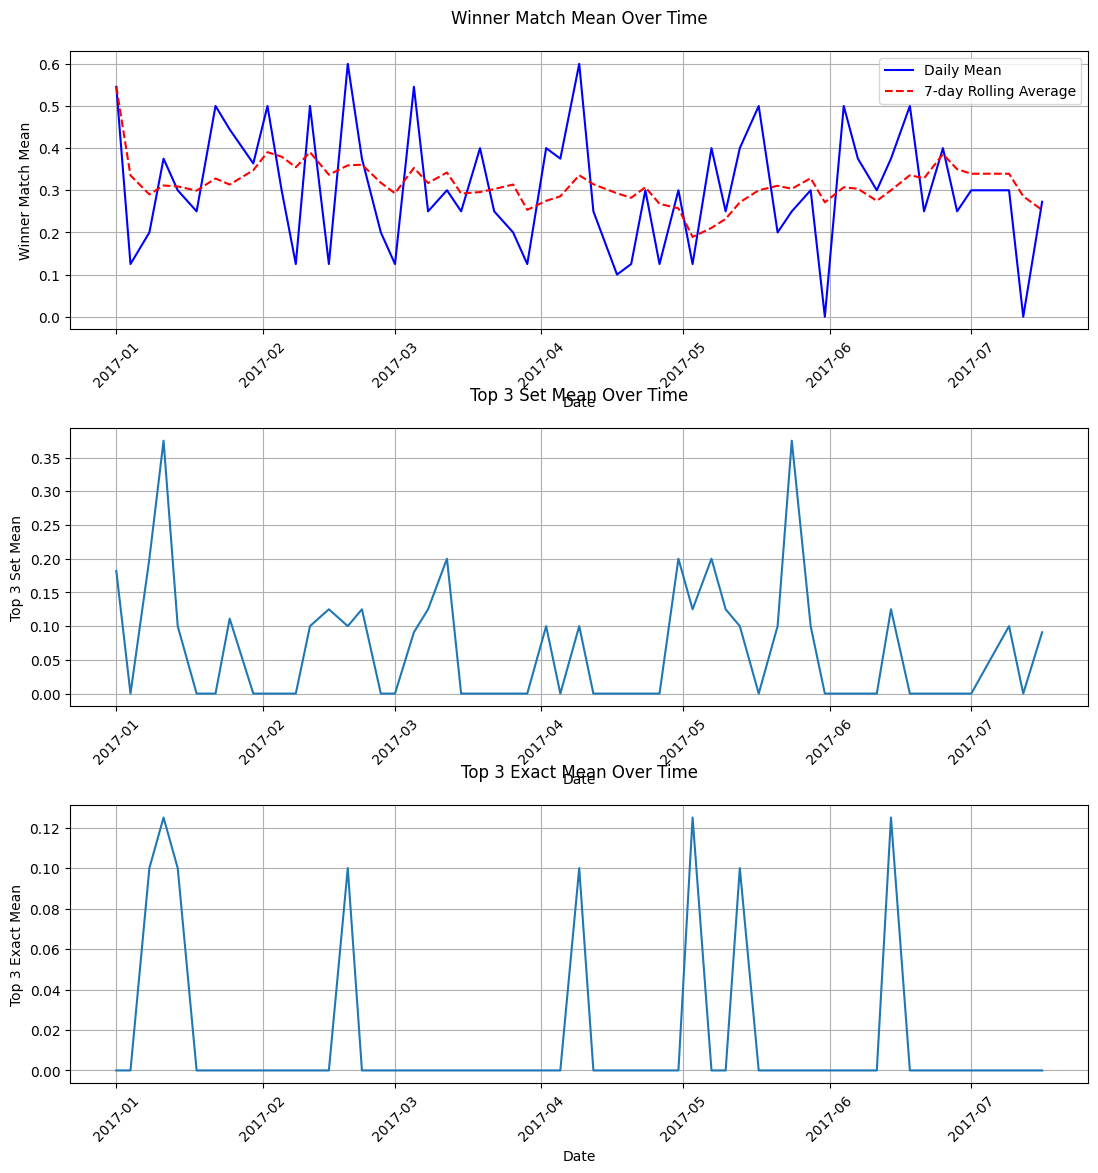

,race_date,winner_match_mean,top3set_mean,top3exact_mean
0,2017-01-01,0.54545,0.18182,0.00000
1,2017-01-04,0.12500,0.00000,0.00000
2,2017-01-08,0.20000,0.20000,0.10000
3,2017-01-11,0.37500,0.37500,0.12500
4,2017-01-14,0.30000,0.10000,0.10000
5,2017-01-18,0.25000,0.00000,0.00000
6,2017-01-22,0.50000,0.00000,0.00000
7,2017-01-25,0.44444,0.11111,0.00000
8,2017-01-30,0.36364,0.00000,0.00000
9,2017-02-02,0.50000,0.00000,0.00000


In [636]:
convert_race_dates_and_plot_metrics3(daily_eval)

In [630]:
daily_eval.head(5)

,race_date,winner_match_mean,top3set_mean,top3exact_mean
0,20170101,0.54545,0.18182,0.00000
1,20170104,0.12500,0.00000,0.00000
2,20170108,0.20000,0.20000,0.10000
3,20170111,0.37500,0.37500,0.12500
4,20170114,0.30000,0.10000,0.10000


In [623]:
eval_df.head(20)

,race_id,winner_match,top3set,top3exact,clean_race_date
0,2016-297,1.00000,0.00000,0.00000,20170101
1,2016-298,0.00000,0.00000,0.00000,20170101
2,2016-299,1.00000,0.00000,0.00000,20170101
3,2016-300,1.00000,1.00000,0.00000,20170101
4,2016-301,0.00000,0.00000,0.00000,20170101
5,2016-302,0.00000,0.00000,0.00000,20170101
6,2016-303,1.00000,0.00000,0.00000,20170101
7,2016-304,1.00000,0.00000,0.00000,20170101
8,2016-305,0.00000,0.00000,0.00000,20170101
9,2016-306,1.00000,1.00000,0.00000,20170101


# unsuccessul features

##  feature from train df only

In [225]:
def convert_date_to_int(date_str: str) -> int:
    """
    Convert date string in YYYY-MM-DD format to integer that preserves ordering
    
    Args:
        date_str: Date string in YYYY-MM-DD format
        
    Returns:
        Integer in format YYYYMMDD
        
    Example:
        '2015-11-18' -> 20151118
        '2016-03-31' -> 20160331
    """
    # Remove hyphens and convert to integer
    return int(date_str.replace('-', ''))

In [226]:
race_df = pd.read_csv('../data/race-result-race.csv')
race_df['clean_race_date'] = race_df['race_date'].apply(lambda x:convert_date_to_int(x))
race_df['year'] = race_df['race_date'].apply(lambda x:x[0:4])
race_df['race_course_track'] = race_df['race_course'] + '_' + race_df['track']

In [227]:
train_years = ['2014','2015','2016']
val_years = ['2017']
train_race_df = race_df[race_df['year'].isin(train_years)]


In [228]:
# race_course_feature
# Pattern classification
def classify_race_pattern(times):
    times = times.astype(float)
    diffs = np.diff(times)
    if all(diffs < 0):
        return 'progressive_speedup'
    elif all(diffs > 0):
        return 'progressive_slowdown'
    elif diffs[0] < 0 and diffs[-1] > 0:
        return 'middle_burst'
    elif diffs[0] > 0 and diffs[-1] < 0:
        return 'strong_finish'
    return 'mixed'


race_course_features = []
for i,row in tqdm(train_race_df.iterrows(), total=len(train_race_df)):
    rpost_items = np.array(row['sectional_time'].split(' ')).astype(float)    
    item_dict = dict()
    # item_dict['race_id'] = row['race_id']
    item_dict['race_course_track'] = row['race_course_track']
    item_dict['race_stime_min'] = stime_items.min()
    item_dict['race_stime_max'] = stime_items.max()
    item_dict['race_stime_mean'] = stime_items.mean()
    item_dict['race_stime_std'] = stime_items.std()
    stime_diffs = np.diff(stime_items)
    # item_dict['race_stime_diffs'] = stime_diffs
    item_dict['race_stime_pace_variance'] = np.var(stime_diffs)
    item_dict['race_stime_max_pace_change'] = np.abs(stime_diffs).max()
    item_dict['race_stime_skewness'] = stats.skew(stime_items)
    
    item_dict['race_stime_first_half_avg'] = np.mean(stime_items[:len(stime_items)//2].astype(float))
    item_dict['race_stime_second_half_avg'] = np.mean(stime_items[len(stime_items)//2:].astype(float))
    item_dict['race_stime_speed_bias'] = item_dict['race_stime_second_half_avg'] - item_dict['race_stime_first_half_avg']  # Negative means faster finish

    # Percentile-based features
    stime_percentiles = np.percentile(stime_items.astype(float), [25, 75])
    item_dict['race_stime_iqr'] = stime_percentiles[1] - stime_percentiles[0]

    # Section comparisons
    item_dict['race_stime_fastest_section_idx'] = np.argmin(stime_items.astype(float))
    item_dict['race_stime_slowest_section_idx'] = np.argmax(stime_items.astype(float))

    # Trend analysis
    item_dict['race_stime_faster'] = all(stime_diffs < 0)  # True if consistently speeding up
    item_dict['race_stime_slower'] = all(stime_diffs > 0)  # True if consistently slowing down

  
    # item_dict['race_pattern'] = classify_race_pattern(stime_items)
    race_course_features.append(item_dict)    
# break
# stime_

train_rc_features = pd.DataFrame.from_dict(race_course_features)
train_rc_features['race_stime_faster'] = train_rc_features['race_stime_faster'].astype(np.int8) 
train_rc_features['race_stime_slower'] = train_rc_features['race_stime_slower'].astype(np.int8) 

  0%|          | 0/1856 [00:00<?, ?it/s]

In [97]:
train_rc_features.head(5)

,race_course_track,race_stime_min,race_stime_max,race_stime_mean,race_stime_std,race_stime_pace_variance,race_stime_max_pace_change,race_stime_skewness,race_stime_first_half_avg,race_stime_second_half_avg,race_stime_speed_bias,race_stime_iqr,race_stime_fastest_section_idx,race_stime_slowest_section_idx,race_stime_faster,race_stime_slower
0,"Sha Tin_TURF - ""A"" COURSE",13.59000,23.55000,20.58250,4.07222,13.42247,8.49000,-1.09679,17.83500,23.33000,5.49500,3.26250,0,3,0,1
1,"Sha Tin_TURF - ""A"" COURSE",13.55000,22.89000,20.38500,3.95432,15.75707,8.70000,-1.14070,17.90000,22.87000,4.97000,2.78500,0,2,0,0
2,"Sha Tin_TURF - ""A"" COURSE",22.25000,24.06000,23.32333,0.77633,2.59210,1.81000,-0.56894,24.06000,22.95500,-1.10500,0.90500,1,0,0,0
3,"Sha Tin_TURF - ""A"" COURSE",22.47000,23.42000,22.79000,0.44550,0.21622,0.94000,0.70684,23.42000,22.47500,-0.94500,0.47500,2,0,1,0
4,"Sha Tin_TURF - ""A"" COURSE",22.62000,24.00000,23.08667,0.64588,0.49000,1.38000,0.70660,24.00000,22.63000,-1.37000,0.69000,1,0,0,0


In [229]:
groupby_feats1 = ['race_course_track']
numfeats = [col for col in train_rc_features.columns if 'stime' in col]
stat = ['median', 'mean', 'std'] 
print(numfeats)

agg_recipies = [
    [groupby_feats1, numfeats, stat],
]

res_dfs = project_utils.groupby_agg_execution(agg_recipies, train_rc_features, verbose=False)

['race_stime_min', 'race_stime_max', 'race_stime_mean', 'race_stime_std', 'race_stime_pace_variance', 'race_stime_max_pace_change', 'race_stime_skewness', 'race_stime_first_half_avg', 'race_stime_second_half_avg', 'race_stime_speed_bias', 'race_stime_iqr', 'race_stime_fastest_section_idx', 'race_stime_slowest_section_idx', 'race_stime_faster', 'race_stime_slower']


In [111]:
res_dfs.keys()

dict_keys(['race_course_track'])

In [230]:
train_track_features = res_dfs['race_course_track']
train_track_features.shape

(11, 46)

In [114]:
train_track_features.head(2)

,race_course_track,race_course_track_race_stime_min_median,race_course_track_race_stime_min_mean,race_course_track_race_stime_min_std,race_course_track_race_stime_max_median,race_course_track_race_stime_max_mean,race_course_track_race_stime_max_std,race_course_track_race_stime_mean_median,race_course_track_race_stime_mean_mean,race_course_track_race_stime_mean_std,race_course_track_race_stime_std_median,race_course_track_race_stime_std_mean,race_course_track_race_stime_std_std,race_course_track_race_stime_pace_variance_median,race_course_track_race_stime_pace_variance_mean,race_course_track_race_stime_pace_variance_std,race_course_track_race_stime_max_pace_change_median,race_course_track_race_stime_max_pace_change_mean,race_course_track_race_stime_max_pace_change_std,race_course_track_race_stime_skewness_median,race_course_track_race_stime_skewness_mean,race_course_track_race_stime_skewness_std,race_course_track_race_stime_first_half_avg_median,race_course_track_race_stime_first_half_avg_mean,race_course_track_race_stime_first_half_avg_std,race_course_track_race_stime_second_half_avg_median,race_course_track_race_stime_second_half_avg_mean,race_course_track_race_stime_second_half_avg_std,race_course_track_race_stime_speed_bias_median,race_course_track_race_stime_speed_bias_mean,race_course_track_race_stime_speed_bias_std,race_course_track_race_stime_iqr_median,race_course_track_race_stime_iqr_mean,race_course_track_race_stime_iqr_std,race_course_track_race_stime_fastest_section_idx_median,race_course_track_race_stime_fastest_section_idx_mean,race_course_track_race_stime_fastest_section_idx_std,race_course_track_race_stime_slowest_section_idx_median,race_course_track_race_stime_slowest_section_idx_mean,race_course_track_race_stime_slowest_section_idx_std,race_course_track_race_stime_faster_median,race_course_track_race_stime_faster_mean,race_course_track_race_stime_faster_std,race_course_track_race_stime_slower_median,race_course_track_race_stime_slower_mean,race_course_track_race_stime_slower_std
0,"Happy Valley_TURF - ""A"" COURSE",22.99500,20.71226,4.51233,24.39000,25.36313,1.81016,23.48667,23.40191,1.92967,1.35544,1.84206,1.63844,2.00096,4.88883,5.87544,2.89500,3.83187,3.26914,-0.12201,-0.07547,0.78228,23.82500,22.49121,4.39373,23.64000,23.81973,0.84688,-0.44000,1.32852,4.04285,1.16500,1.60840,1.52435,1.00000,1.29808,1.09791,0.00000,0.93269,1.11437,0.00000,0.16346,0.37068,0.00000,0.12019,0.32597
1,"Happy Valley_TURF - ""B"" COURSE",22.98000,20.50457,4.51400,24.41500,25.51085,2.00364,23.48500,23.34649,1.96114,1.58717,1.97962,1.63447,2.53601,5.55892,6.23762,3.49500,4.16793,3.33367,-0.17046,-0.05671,0.83323,23.87000,22.45639,4.53552,23.61000,23.73327,0.83003,-0.52500,1.27688,4.20237,1.28000,1.69468,1.57438,1.00000,1.24468,1.08155,0.00000,0.90957,1.10773,0.00000,0.15426,0.36216,0.00000,0.14362,0.35164


##  train_df horse level groupby

In [231]:
# train_df horse level groupby
horse_race_df = pd.read_parquet('../feature_data/horse_race_df.parquet')
horse_race_df_train =  horse_race_df.loc[train_idx].copy()


In [232]:
groupby_feats1 = ['horse_id']
numfeats = ['clean_length_behind_winner', 'clean_actual_weight', 'clean_declared_horse_weight', 'clean_win_odds', 
            'running_position_1', 'running_position_2', 'running_position_3', 'running_position_4', 
            'running_position_5', 'running_position_6', 'race_distance', 'clean_position']
stat = ['median', 'mean', 'std'] 

agg_recipies = [
    [groupby_feats1, numfeats, stat],
]
res_dfs = project_utils.groupby_agg_execution(agg_recipies, horse_race_df_train, verbose=False)
train_horse_groupby_features = res_dfs['horse_id']
train_horse_groupby_features.shape

(1895, 37)

In [157]:
train_horse_groupby_features.head(2)

,horse_id,horse_id_clean_length_behind_winner_median,horse_id_clean_length_behind_winner_mean,horse_id_clean_length_behind_winner_std,horse_id_clean_actual_weight_median,horse_id_clean_actual_weight_mean,horse_id_clean_actual_weight_std,horse_id_clean_declared_horse_weight_median,horse_id_clean_declared_horse_weight_mean,horse_id_clean_declared_horse_weight_std,horse_id_clean_win_odds_median,horse_id_clean_win_odds_mean,horse_id_clean_win_odds_std,horse_id_running_position_1_median,horse_id_running_position_1_mean,horse_id_running_position_1_std,horse_id_running_position_2_median,horse_id_running_position_2_mean,horse_id_running_position_2_std,horse_id_running_position_3_median,horse_id_running_position_3_mean,horse_id_running_position_3_std,horse_id_running_position_4_median,horse_id_running_position_4_mean,horse_id_running_position_4_std,horse_id_running_position_5_median,horse_id_running_position_5_mean,horse_id_running_position_5_std,horse_id_running_position_6_median,horse_id_running_position_6_mean,horse_id_running_position_6_std,horse_id_race_distance_median,horse_id_race_distance_mean,horse_id_race_distance_std,horse_id_clean_position_median,horse_id_clean_position_mean,horse_id_clean_position_std
0,A001,4.00000,4.00000,NaN,125.00000,125.00000,NaN,1083.00000,1083.00000,NaN,49.00000,49.00000,NaN,9.00000,9.00000,NaN,7.00000,7.00000,NaN,11.00000,11.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200.00000,1200.00000,NaN,11.00000,11.00000,NaN
1,A002,0.75000,0.70000,0.57663,130.00000,129.00000,3.60555,1096.00000,1095.00000,6.55744,3.69922,4.63281,2.43686,4.00000,3.66667,1.52753,4.00000,4.66667,1.15470,4.00000,4.66667,1.15470,2.00000,3.66667,2.88675,2.00000,2.00000,NaN,2.00000,2.00000,NaN,1600.00000,1800.00000,346.41016,2.00000,2.00000,0.00000


##  train_df horse race-track level groupby

In [233]:
groupby_feats = ['horse_id', 'race_course_track']
numfeats = ['running_position_1', 'running_position_2', 'running_position_3', 'running_position_4', 
            'running_position_5', 'running_position_6', 'clean_finish_time', 'clean_win_odds']
stat = ['median', 'mean', 'std']  # {'ptp':np.ptp}]#{'sharp':project_utils.get_array_sharpe}]

agg_recipies = [
    [groupby_feats, numfeats, stat],
]
res_dfs = project_utils.groupby_agg_execution(agg_recipies, horse_race_df_train, verbose=False)
train_horse_track_groupby_stat = res_dfs['horse_id_race_course_track']
train_horse_track_groupby_stat.shape

(10665, 26)

## jockey, trainer performance features in train dataset

In [343]:
groupby_feats1 = ['jockey'] 
groupby_feats2 = ['trainer']
numfeats = ['clean_position']
# stat = ['median', 'mean', 'std', 'count']  # {'ptp':np.ptp}]#{'sharp':project_utils.get_array_sharpe}]
stat = ['count']

agg_recipies = [
    [groupby_feats1, numfeats, stat],
    [groupby_feats2, numfeats, stat],
]
res_dfs = project_utils.groupby_agg_execution(agg_recipies, horse_race_df, verbose=False)

train_jockey_groupby_features = res_dfs['jockey']
train_trainer_groupby_features = res_dfs['trainer']
print(train_jockey_groupby_features.shape)
print(train_trainer_groupby_features.shape)

(105, 2)
(93, 2)


# horse performance feature

## feature derived from main horse data

In [235]:
horse_feats = pd.DataFrame()
horse_feats['awght_dwght_ratio'] = horse_race_df['clean_actual_weight'] / horse_race_df['clean_declared_horse_weight']
horse_feats['awght_dwght_delta'] = horse_race_df['clean_actual_weight'] - horse_race_df['clean_declared_horse_weight']

## final feature set aggregation

In [236]:
horse_race_df = pd.read_parquet('../feature_data/horse_race_df.parquet')

In [ ]:
# concat: bin_df, freq_df, horse_feats
# merge: train_track_features, train_horse_groupby_features, train_horse_track_groupby_stat
#        train_jockey_groupby_features, train_trainer_groupby_features

In [237]:
print(df0.shape, bin_df.shape, freq_df.shape, horse_feats.shape)

(29520, 14) (29520, 27) (29520, 6) (29520, 2)


In [312]:
# concat
df1 = pd.concat([df0, bin_df, freq_df, horse_feats], axis=1)
df1.shape

(29520, 49)

In [341]:
# merge_id_cols = [['race_course_track', 'horse_id', 'jockey', 'trainer']
merge_dfs = [train_track_features, train_horse_groupby_features, train_horse_track_groupby_stat,
            train_jockey_groupby_features, train_trainer_groupby_features]
feature_cols = []
for mdf in merge_dfs:
    use_cols = [c for c in mdf.columns if c not in merge_id_cols]
    feature_cols += use_cols
print(len(feature_cols))

df2 = horse_race_df.copy()
# df2 = df2.merge(right=train_track_features, on = 'race_course_track', how='left')
# df2 = df2.merge(right=train_horse_groupby_features, on = 'horse_id', how='left')
# df2 = df2.merge(right=train_horse_track_groupby_stat, on = ['horse_id', 'race_course_track'], how='left')
df2 = df2.merge(right=train_jockey_groupby_features, on = 'jockey', how='left')
df2 = df2.merge(right=train_trainer_groupby_features, on = 'trainer', how='left')

use_cols = [c for c in df2.columns if c in feature_cols]

df2 = df2[use_cols]
df2.shape

113


(29520, 8)

In [319]:
# df3 = pd.concat([df1, df2], axis=1)

df3 = df1.copy()
train_df = df3.loc[train_idx]
val_df = df3.loc[val_idx]


params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'n_estimators':300,
    'num_leaves': 32,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,  # Column sampling
    'bagging_fraction': 0.8,  # Row sampling 
    'bagging_freq': 5,
    'verbose': -1,
    'max_depth': -1,
    'min_child_samples': 20,
    'is_unbalance': True  # Handle unbalanced datasets
}

target1 = 'is_winner'
target2 = 'is_top3'
basic_cat_features = basic_cat_ordinal_df.columns.tolist()




In [320]:
# is_winner modelling
df_winner = df3.copy()
df_winner[target1] = horse_race_df[target1]

train_df = df_winner.loc[train_idx]
val_df = df_winner.loc[val_idx]

print(train_df.shape, val_df.shape)
model_winner, val_winner_preds = train_lightgbm_model(train_df, val_df, target1,
                                        cat_features=basic_cat_features, params=params)

(23232, 50) (6288, 50)
Validation LogLoss: 0.3200


In [321]:
# is_top3 modelling
df_top3 = df3.copy()
df_top3[target2] = horse_race_df[target2]

train_df = df_top3.loc[train_idx]
val_df = df_top3.loc[val_idx]

print(train_df.shape, val_df.shape)
model_top3, val_top3_preds = train_lightgbm_model(train_df, val_df, target2,
                                        cat_features=basic_cat_features, params=params)

(23232, 50) (6288, 50)
Validation LogLoss: 0.4428


## top 1 model evaluation

In [322]:
val_horse_race_df = horse_race_df.loc[val_idx].reset_index(drop=True)
pred_col = f'lgbm_v1_preds_{target1}'
val_horse_race_df[pred_col] = val_winner_preds

eval_dict = {}
ground_truth = {}
lgbm_v1_preds = [] 

for race in val_horse_race_df['race_id'].unique():
    race_df = val_horse_race_df[val_horse_race_df['race_id']==race]
    n_horse = race_df.shape[0]    
    eval_dict[race] = {}
    eval_dict[race]['ground_truth'] = race_df['clean_position'].values
    eval_dict[race][pred_col] = race_df[pred_col].values

In [323]:
eval_result, lgbmv1_iswinner_results_df = evaluate_prediction_sets(eval_dict)

In [324]:
lgbmv1_iswinner_results_df

,lgbm_v1_preds_is_winner
Winner Match,0.41292
Top 3 Set Match,0.11742
Top 3 Exact Match,0.03718


In [325]:
pred_col = f'lgbm_v1_preds_{target1}'
check_race_id = val_horse_race_df['race_id'].sample(1).values[0]
use_cols = ['race_id', 'horse_id', 'clean_position', target, pred_col]
val_horse_race_df[val_horse_race_df['race_id']==check_race_id][use_cols]

,race_id,horse_id,clean_position,is_top3,lgbm_v1_preds_is_winner
559,2016-342,A113,1,1,0.92016
560,2016-342,A002,2,1,0.90098
561,2016-342,V118,3,1,0.12439
562,2016-342,V125,4,0,0.64945
563,2016-342,V050,5,0,0.06700
564,2016-342,T281,6,0,0.31102
565,2016-342,A111,7,0,0.00044
566,2016-342,S245,8,0,0.00249
567,2016-342,V051,9,0,0.00058
568,2016-342,S414,10,0,0.00029


## top 3 model evaluation

In [326]:
val_horse_race_df = horse_race_df.loc[val_idx].reset_index(drop=True)
pred_col = f'lgbm_v1_preds_{target2}'
val_horse_race_df[pred_col] = val_top3_preds

eval_dict = {}
ground_truth = {}
lgbm_v1_preds = [] 

for race in val_horse_race_df['race_id'].unique():
    race_df = val_horse_race_df[val_horse_race_df['race_id']==race]
    n_horse = race_df.shape[0]    
    eval_dict[race] = {}
    eval_dict[race]['ground_truth'] = race_df['clean_position'].values
    eval_dict[race][pred_col] = race_df[pred_col].values

eval_result, lgbmv1_istop3_results_df = evaluate_prediction_sets(eval_dict)

In [327]:
lgbmv1_istop3_results_df

,lgbm_v1_preds_is_top3
Winner Match,0.42857
Top 3 Set Match,0.13503
Top 3 Exact Match,0.03131


# top1 + top3 model 

In [338]:
val_horse_race_df = horse_race_df.loc[val_idx].reset_index(drop=True)
pred_col = f'lgbm_v1_preds_combine'
val_horse_race_df[pred_col] = val_top3_preds

eval_dict = {}
ground_truth = {}
lgbm_v1_preds = [] 

for race in val_horse_race_df['race_id'].unique():
    race_df = val_horse_race_df[val_horse_race_df['race_id']==race]
    n_horse = race_df.shape[0]    
    eval_dict[race] = {}
    eval_dict[race]['ground_truth'] = race_df['clean_position'].values
    eval_dict[race][pred_col] = race_df[pred_col].values

eval_result, lgbmv1_combine_results_df = evaluate_prediction_sets(eval_dict)

In [339]:
lgbmv1_combine_results_df

,lgbm_v1_preds_combine
Winner Match,0.42857
Top 3 Set Match,0.13503
Top 3 Exact Match,0.03131


In [124]:
y_pred_ranks = np.argsort(y_pred_proba)
y_pred_ranks

array([4, 0, 3, 2, 1])

In [112]:
np.argsort(y_pred_proba)[::-1]

array([1, 3, 2, 0, 4])

# ad-hoc data analysis

In [6]:
print(val_df.columns.tolist())

['finishing_position', 'horse_number', 'horse_name', 'horse_id', 'jockey', 'trainer', 'actual_weight', 'declared_horse_weight', 'draw', 'length_behind_winner', 'running_position_1', 'running_position_2', 'running_position_3', 'running_position_4', 'finish_time', 'win_odds', 'running_position_5', 'running_position_6', 'race_id', 'clean_actual_weight', 'clean_declared_horse_weight', 'clean_length_behind_winner', 'clean_finish_time', 'clean_win_odds', 'clean_position', 'is_winner', 'is_top3', 'src', 'race_date', 'race_course', 'race_number', 'race_class', 'race_distance', 'track_condition', 'race_name', 'track', 'sectional_time', 'incident_report', 'race_course_track', 'clean_race_date', 'clean_position_mavg_3', 'clean_position_mavg_5', 'clean_position_mavg_7', 'year']


In [ ]:
project_utils.analyze_dataframe(val_df)